In [2]:
import sys, os, pathlib
sys.path.append("/root/shared/gitrepos/smart-comp-sci/utils")
sys.path.append("/root/shared/gitrepos/smart-comp-sci/mechanotransduction-example")
import smart_analysis
from mechanotransduction_ode import mechanotransduction_ode_calc
from matplotlib import pyplot as plt
import matplotlib
params = {'axes.labelsize': 12,
            'axes.titlesize': 6,
            'legend.fontsize': 10,
            'xtick.labelsize':10,
            'ytick.labelsize': 10,
            'figure.figsize': (5.5,4),
            'pdf.fonttype': 42,
            'ps.fonttype': 42,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'legend.loc': "best"}
matplotlib.rcParams.update(params)
import numpy as np
cur_dir = "/root/shared/gitrepos/smart-comp-sci/mechanotransduction-example"

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
if "results-redo" not in os.listdir(cur_dir):
    files_dir = "/root/scratch/smart-comp-sci-data/mechanotransduction/fig-sweep-redo"
    npy_dir = pathlib.Path("/root/shared/gitrepos/smart-comp-sci/mechanotransduction-example/results-redo")
    npy_dir.mkdir(exist_ok=True)
    test_folders = os.listdir(files_dir)
    condition_str = []
    for i in range(len(test_folders)):
        subfolders = os.listdir(f"{files_dir}/{test_folders[i]}")
        if len(subfolders) != 2: # should be 2 folders, one with mesh and one with results
            condition_str.append("")
            continue
        for j in range(len(subfolders)):
            if "mesh" in subfolders[j]:
                for file in os.listdir(f"{files_dir}/{test_folders[i]}/{subfolders[j]}"):
                    if file.endswith(".h5") and "mesh" in file:
                        mesh_file = f"{files_dir}/{test_folders[i]}/{subfolders[j]}/{file}"
                        break
            elif "results" in subfolders[j]:
                results_folder = f"{files_dir}/{test_folders[i]}/{subfolders[j]}"
                condition_str.append(subfolders[j])
            else:
                ValueError("Folders do not match expected structure for analysis")
        if mesh_file=="" or results_folder=="":
            ValueError("Folders do not match expected structure for analysis")

        if "circle" in results_folder: #results_folder.endswith("symm=0"):
            axisymm = True
        else:
            axisymm = False
        tVec, results_all = smart_analysis.analyze_all(
            mesh_file=mesh_file, results_path=results_folder, display=False, axisymm=axisymm)
        results_all.insert(0, tVec) # add time as first element in list
        max_length = len(tVec)
        for j in range(len(results_all)):
            if len(results_all[j]) > max_length:
                max_length = len(results_all[j])
        for j in range(len(results_all)):
            num_zeros = max_length - len(results_all[j])
            for k in range(num_zeros):
                results_all[j].append(0)
        np.save(npy_dir / f"{condition_str[i]}_results.npy", results_all)

Text(0.5, 0, 'Time (s)')

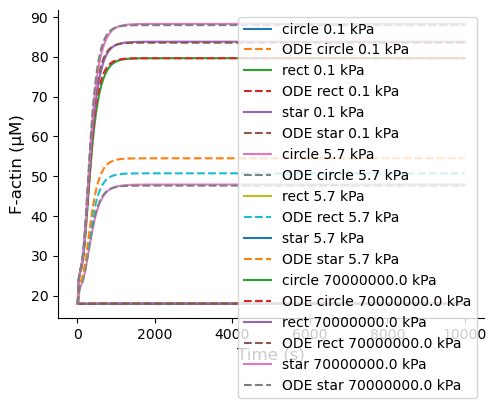

In [9]:
contact_rad = 13
stiffness_vec = [0.1, 5.7, 70000000.0]
shape_vec = ["circle", "rect", "star"]
symm_vec = [0, 0.25, 0.5]
cyto_vol = 480
pm_area = 320
nuc_vol = 70.6
nm_area = 58.5
Ac = 133
# geoParam = [cyto_vol, nuc_vol, pm_area, nm_area, Ac]
geoParam = [[1925.03/4, nuc_vol, 1294.5/4, nm_area, Ac], [480.1, nuc_vol, 332.7, nm_area, Ac], [952.9/2, nuc_vol, 681.1/2, nm_area, Ac]]
var_names_all = ["Cofilin_P", "Fak", "mDia", "LaminA", "FActin", "RhoA_GTP", "mDia_A", "NPC_A", "GActin", "NPC",
        "ROCK_A", "Myo", "Cofilin_NP", "LaminA_p", "YAPTAZ_nuc", "pFak", "YAPTAZ_phos", "YAPTAZ", "RhoA_GDP", "LIMK",
        "Myo_A", "ROCK", "Positionboolean", "LIMK_A", "MRTF", "MRTF_nuc"]
# var_names_saved = ["Cofilin_NP", "Emod", "FActin", "GActin", "LaminA", "LIMK_A", "mDia_A", "MRTF", "MRTF_bound", "MRTF_nuc", 
#                    "Myo_A", "NPC_A", "pFAK", "RhoA_GDP", "RhoA_GTP", "ROCK_A", "YAPTAZ", "YAPTAZ_nuc", "YAPTAZ_phos"]
var_names_saved = ["Cofilin_NP", "Emod", "FActin", "GActin", "LaminA", "LIMK_A", "mDia_A", 
                   "Myo_A", "NPC_A", "pFAK", "RhoA_GDP", "RhoA_GTP", "ROCK_A", "YAPTAZ", "YAPTAZ_nuc", "YAPTAZ_phos"]
plot_name = "FActin"
ode_idx = var_names_all.index(plot_name)
results_idx = var_names_saved.index(plot_name) + 1 # add one because time is first el
fig, ax = plt.subplots()
for stiffness in stiffness_vec:
    for i in range(len(shape_vec)):
        file_cur = f"{cur_dir}/results-redo/results_{shape_vec[i]}_R{contact_rad}smooth_{stiffness}kPa_wellmixed=True_results.npy"
        results_cur = np.load(file_cur)
        plt.plot(results_cur[0], results_cur[results_idx],label=f"{shape_vec[i]} {stiffness} kPa")
        # plot ode solution
        t_ode, ode_results = mechanotransduction_ode_calc([0, 10000], stiffness, geoParam[i])
        plt.plot(t_ode, ode_results[:,ode_idx], linestyle='dashed', label=f"ODE {shape_vec[i]} {stiffness} kPa")

plt.legend()
plt.ylabel("F-actin (μM)")
plt.xlabel('Time (s)')
# plt.savefig("/root/shared/gitrepos/pyplots/Factin_notmixed.pdf", format="pdf")

Text(0.5, 0, 'Time (s)')

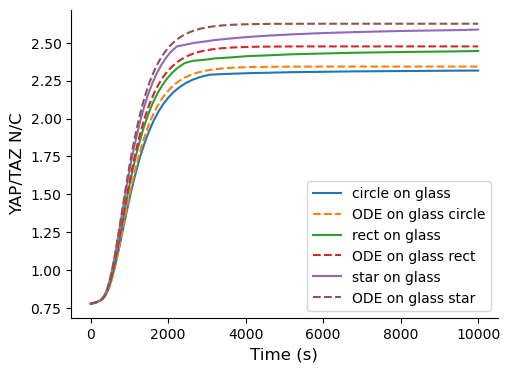

In [6]:
stiffness_vec = [7e7]#[0.1, 5.7, 70000000.0]
shape_vec = ["circle", "rect", "star"]
symm_vec = [0, 0.25, 0.5]
# plot YAP/TAZ N/C ratio
plot_names = ["YAPTAZ_phos", "YAPTAZ", "YAPTAZ_nuc"]
ode_idx = []
results_idx = []
for name in plot_names:
    results_idx.append(var_names_saved.index(name) + 1) # add one because time is first el
    ode_idx.append(var_names_all.index(name))
fig, ax = plt.subplots()
for stiffness in stiffness_vec:
    for i in range(len(shape_vec)):
        file_cur = f"{cur_dir}/results-redo/results_{shape_vec[i]}_R{contact_rad}smooth_{stiffness}kPa_wellmixed=False_results.npy"
        results_cur = np.load(file_cur)
        yaptaz_curratio = results_cur[results_idx[2]]/(results_cur[results_idx[0]]+results_cur[results_idx[1]])
        plt.plot(results_cur[0], yaptaz_curratio, label=f"{shape_vec[i]} on glass")#{stiffness} kPa")
        # plot ode solution
        t_ode, ode_results = mechanotransduction_ode_calc([0, 10000], stiffness, geoParam[i])
        ode_yaptazratio = ode_results[:,ode_idx[2]]/(ode_results[:,ode_idx[0]]+ode_results[:,ode_idx[1]])
        plt.plot(t_ode, ode_yaptazratio, linestyle='dashed', label=f"ODE on glass {shape_vec[i]}")#{stiffness} kPa")

plt.legend()
plt.ylabel("YAP/TAZ N/C")
plt.xlabel('Time (s)')
# plt.savefig("/root/shared/gitrepos/pyplots/yaptaz_notmixed.pdf", format="pdf")